# 1.4 Unbiasing the data

### Imports

In [972]:
## import required packages
import os, math, sys
import numpy as np
import matplotlib.pyplot as plt
import simtk.openmm.app  as omm_app
import simtk.openmm as omm
import simtk.unit as unit
from tqdm import tqdm
import mdtraj
from FastMBAR import *
from tqdm.notebook import tqdm_notebook

### Aims of this Notebook

The aim of this notebook is to teach you how to unbias the obtained data from the umbrella sampling trajectories and how to succesfully reconstruct the free energy profile for the dissociation of NaCl. 

You will learn: 
1. How to read in the obtained distances
2. How to calculate the bias that was applied on the trajectories by the biasing harmonic potential
4. How to prepare the data for unbiasing. 
3. How to recover the dissociation free energy profile with the Weighted Histogram Analysis Method (WHAM) and the Multistate Bennett Acceptance Ratio (MBAR). 

## Introduction

In [1023]:
# read distance values from the umbrella sampling

dists = []
M=15 # M umbrella centers/windows we used

for window in range(M):
    dist = np.loadtxt(f"output_files/dist_win_{window+1}.csv", delimiter = ",")
    dists.append(dist*10) # We convert them to Angstroms

Now that we fetched the data, we have to calculate how much we biased each of the datapoints we have, by recalculating the free energy on the biased ensembles used. For this we simply calculate the difference between the umbrella center and the distance sampled, and then with the original potential equation we used for biasing, we can recalculate the energies. We do this for every sampled distance for every window. 

In [1024]:
# Compute the reduced energy 
# We will change all constants to the correct value in order to get the energy in Kcal/mol
K = 10000/418.4 #This was in KJ/nm had to change to Kcal/A
T = 298.15 #This in Kelvins
kbT = 0.593*T #This is in 

umbrella_centers = np.loadtxt("output_files/bias.csv", delimiter = ",")*10 #In angstroms

bias_per_traj = []
for window in range(M):
    bias_per_state = []
    for umb in range(M):
        current = umbrella_centers[umb]
        diff = dists[window] - current
        bias = 0.5*K*(diff**2)/kbT #Remember that we used "0.5*k*(r-r0)^2"
        bias_per_state.append(bias)
    bias_per_traj.append(np.array(bias_per_state).T)
    
bias = np.array(bias_per_traj)

In [1033]:
RC = np.concatenate(dists)
nbins = 50
bin_centers_md = np.linspace(min(RC), max(RC), nbins)

dtrajs = []
ttrajs = []
for window in range(M):
    discrete = np.digitize(dists[window], bins=bin_centers_md)
    dtrajs.append(discrete.astype(int))
    ttrajs.append((np.ones(len(discrete))*window).astype(int))

In [1034]:
bb = []
for win in range(M):
    bb.append(bias[win].T[win])
bb = np.array(bb)

In [1035]:
bias[win].T.shape

(15, 5000)

In [1036]:
from pyemma.thermo import wham
from pyemma.thermo import dtram
from pyemma.thermo import tram
from pyemma.thermo import mbar

mbar_MD = mbar(ttrajs, dtrajs, bias, maxiter=100000)
tram_MD = tram(ttrajs, dtrajs, bias, 1, maxiter=100000)

MBAR:   0%|                                                                                 | 0/100000 [00:00<…

finding connected set:   0%|                                                                    | 0/10 [00:00<…

MBAR init.:   0%|                                                                            | 0/10000 [00:00<…

TRAM:   0%|                                                                                 | 0/100000 [00:00<…

In [1037]:
mbar_PMF = mbar_MD.f_full_state - min(mbar_MD.f_full_state)
tram_PMF = tram_MD.f_full_state - min(tram_MD.f_full_state)

Text(0.5, 0, 'Angstroms')

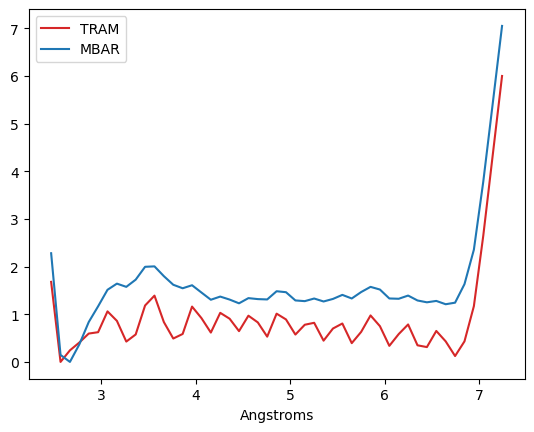

In [1042]:
plt.plot(bin_centers_md, tram_PMF[:-1], label="TRAM", c="C3")
plt.plot(bin_centers_md, mbar_PMF[:-1],  label="MBAR")
plt.legend()
plt.xlabel("Angstroms")

In [1039]:
wham_MD = wham(ttrajs, dtrajs, bb, maxiter=100000)
dtram_MD = dtram(ttrajs, dtrajs, bb, 1, maxiter=100000)

WHAM:   0%|                                                                                 | 0/100000 [00:00<…

DTRAM:   0%|                                                                                | 0/100000 [00:00<…

In [1040]:
wmd_PMF = wham_MD.f - np.min(wham_MD.f)
dtram_PMF = dtram_MD.f - np.min(dtram_MD.f)

Text(0.5, 0, 'Angstroms')

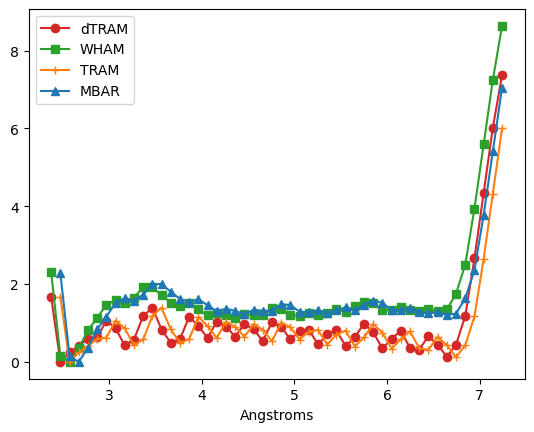

In [1043]:
#plt.plot(bin_centers_md, tram[:-1], "-o", label="TRAM", c="C2")
plt.plot(bin_centers_md, dtram_PMF,"-o", label="dTRAM", c="C3")
plt.plot(bin_centers_md, wmd_PMF,"-s", label="WHAM", c="C2")
plt.plot(bin_centers_md, tram_PMF[:-1], "-+", label="TRAM", c="C1")
plt.plot(bin_centers_md, mbar_PMF[:-1], "-^", label="MBAR", c="C0")
plt.legend()
plt.xlabel("Angstroms")

In [990]:
# #plt.plot(bin_centers_md, mbar[:-1], "-o")
# plt.plot(bin_centers_md[:-1], wmd, "-o", label="WHAM")
# plt.plot(bin_centers_md[:-1], dtram, "-o", label="DTRAM")
# #plt.plot(bin_centers_md, tram[:-1], "-o")
# plt.xlabel("Angstroms")
# plt.legend()

In [1]:
from src.wham import WHAM
dist = np.load("all_dists.npy")
w = WHAM(".")
w.skip = 0
w.KbT = 0.001987204259 * 298.15
w.data = dist.reshape((dist.shape[0], dist.shape[1], 1))
w.k_val = np.ones((dist.shape[0], 1)) * 7000 / 418.4
w.constr_val = np.linspace(2, 7, 16)[:15].reshape((15, 1))  # arbitrary, that was used here
w.converge(0.0001)
w.project_1d([1], 50)
w.plot_strings()    # create a nice one, this also plots the contribution from each simulation

ModuleNotFoundError: No module named 'jax'